In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
# Load data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("train.csv")

Saving train.csv to train.csv


In [3]:
# Check missing values
missing_ratio = df.isnull().sum() / len(df)
cols_to_drop = missing_ratio[missing_ratio > 0.8].index.tolist()
df = df.drop(columns=cols_to_drop)

# Handle missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna('None')

# Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [4]:
# Split data into X and y
X = df.drop(['SalePrice', 'Id'], axis=1)
y = df['SalePrice']

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


[0]	train-rmse:74394.26571	valid-rmse:84508.66513
[50]	train-rmse:21640.24527	valid-rmse:30852.64561
[100]	train-rmse:14667.31403	valid-rmse:26211.96207
[150]	train-rmse:12305.83914	valid-rmse:25503.12405
[200]	train-rmse:10663.46833	valid-rmse:25188.35110
[250]	train-rmse:9385.34798	valid-rmse:25040.63313
[281]	train-rmse:8699.99481	valid-rmse:24961.87751


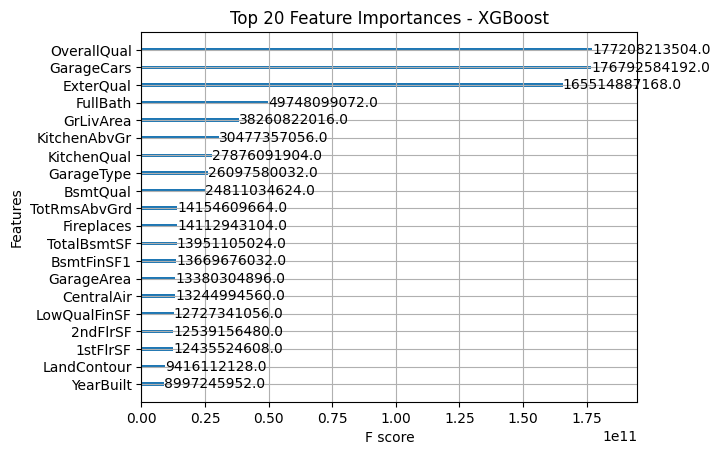

Validation RMSE: 24964.25


In [5]:
# Train XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=50
)

# Feature Importance
xgb.plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("Top 20 Feature Importances - XGBoost")
plt.show()

# Predict on validation set
y_pred = model.predict(dvalid)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse:.2f}")

In [7]:
# Preprocess test.csv
uploaded = files.upload()
test_df = pd.read_csv("test.csv")
test_df = test_df.drop(columns=cols_to_drop)

# Seperate test numeric and categorical columns
test_num_cols = test_df.select_dtypes(include=['int64', 'float64']).columns
test_cat_cols = test_df.select_dtypes(include=['object']).columns

test_df[test_num_cols] = test_df[test_num_cols].fillna(df[test_num_cols].median())
test_df[test_cat_cols] = test_df[test_cat_cols].fillna('None')

# Safe Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    le.fit(df[col])
    test_df[col] = test_df[col].map(lambda s: s if s in le.classes_ else 'Unknown')
    le_classes = np.append(le.classes_, 'Unknown')
    le.classes_ = le_classes
    test_df[col] = le.transform(test_df[col])

# Align columns
test_df_final = test_df[X_train.columns]

# Predict on test.csv
dtest = xgb.DMatrix(test_df_final)
test_predictions = model.predict(dtest)

# Preview first 10 predictions
print("First 10 Predictions on Test Data:")
for i in range(10):
    print(f"Predicted SalePrice: {test_predictions[i]:,.2f}")

Saving test.csv to test.csv
First 10 Predictions on Test Data:
Predicted SalePrice: 140,617.83
Predicted SalePrice: 166,856.98
Predicted SalePrice: 165,924.23
Predicted SalePrice: 182,410.03
Predicted SalePrice: 183,984.09
Predicted SalePrice: 168,818.94
Predicted SalePrice: 182,011.98
Predicted SalePrice: 160,718.23
Predicted SalePrice: 164,795.06
Predicted SalePrice: 118,986.77


In [9]:
# Save Kaggle submission file
uploaded = files.upload()

sample_sub = pd.read_csv("sample_submission.csv")
sample_sub['SalePrice'] = test_predictions
sample_sub.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created!")

Saving sample_submission.csv to sample_submission.csv
Submission file 'submission.csv' created!


In [ ]:
# save model to file

model.save_model("xgboost_model.json")
print("Model saved to 'xgboost_model.json'")

In [ ]:
from google.colab import files
files.download("xgboost_model.json")

In [10]:
# based model on top 10 important features

# Select top 10 features (based on importance from previous run)
top_features = [
    'OverallQual', 'GarageCars', 'ExterQual', 'FullBath', 'GrLivArea',
    'KitchenAbvGr', 'KitchenQual', 'GarageType', 'BsmtQual', 'TotRmsAbvGrd'
]

# Prepare features & target
X = df[top_features]
y = df['SalePrice']

# Split train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost with top 10 features
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model_top10 = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=10,
    verbose_eval=50
)

# Evaluate
y_pred = model_top10.predict(dvalid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE (Top 10 Features): {rmse:.2f}")


[0]	train-rmse:74338.11418	valid-rmse:84648.41205
[50]	train-rmse:28804.70937	valid-rmse:36475.71296
[100]	train-rmse:24434.70241	valid-rmse:32535.13676
[150]	train-rmse:22927.42109	valid-rmse:31564.52717
[171]	train-rmse:22414.32949	valid-rmse:31490.98368
Validation RMSE (Top 10 Features): 31490.98


In [11]:
# Save model
model_top10.save_model("xgboost_model_top10.json")
print("Model saved as xgboost_model_top10.json")

Model saved as xgboost_model_top10.json


In [12]:
from google.colab import files
files.download("xgboost_model_top10.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>